## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.



## 1) Detect chessboard corners from calibration images

../camera_cal/calibration1.jpg
../camera_cal/calibration10.jpg


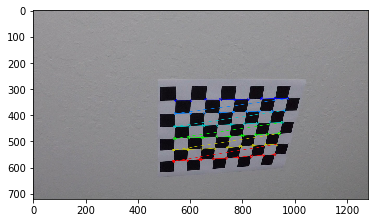

../camera_cal/calibration11.jpg


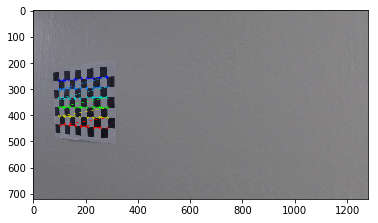

../camera_cal/calibration12.jpg


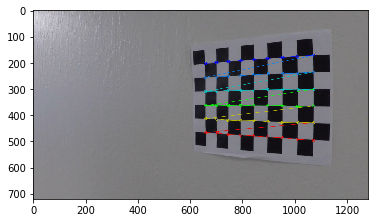

../camera_cal/calibration13.jpg


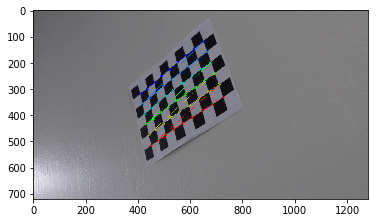

../camera_cal/calibration14.jpg


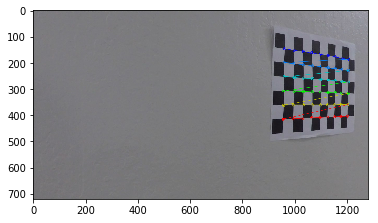

../camera_cal/calibration15.jpg


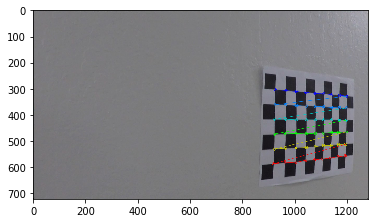

../camera_cal/calibration16.jpg


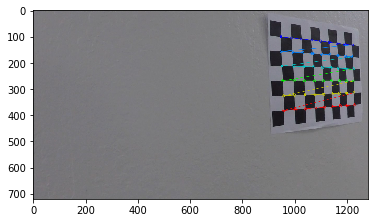

../camera_cal/calibration17.jpg


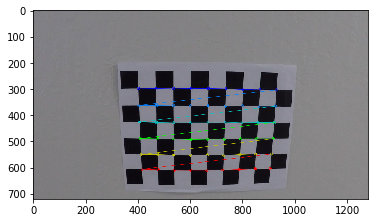

../camera_cal/calibration18.jpg


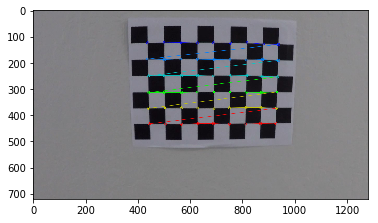

../camera_cal/calibration19.jpg


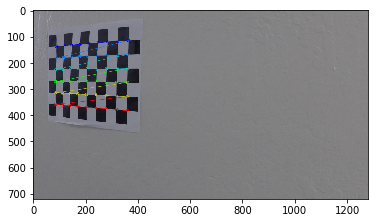

../camera_cal/calibration2.jpg


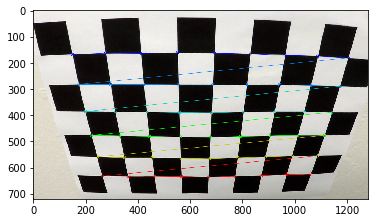

../camera_cal/calibration20.jpg


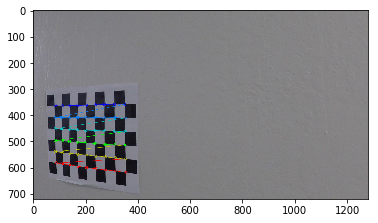

../camera_cal/calibration3.jpg


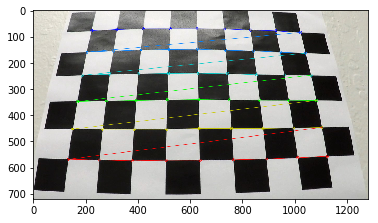

../camera_cal/calibration4.jpg
../camera_cal/calibration5.jpg
../camera_cal/calibration6.jpg


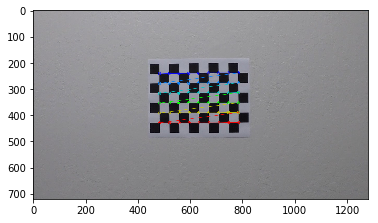

../camera_cal/calibration7.jpg


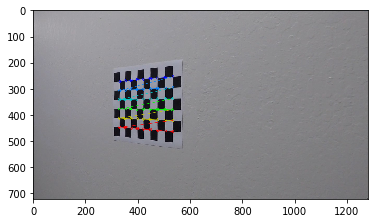

../camera_cal/calibration8.jpg


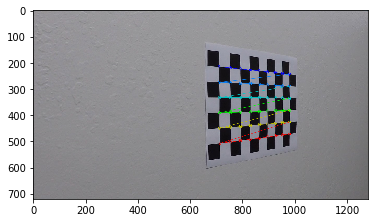

../camera_cal/calibration9.jpg


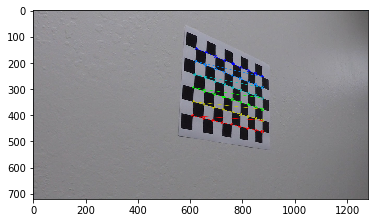

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#%matplotlib qt
import pickle

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9, 3), np.float32)
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        
    # If found, add object points, image points
    if ret == True:
        print(fname)
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        plt.imshow(img)
        plt.show()
    else:
        print(fname)

chessboard_corners = {}
chessboard_corners["objpoints"] = objpoints
chessboard_corners["imgpoints"] = imgpoints
pickle.dump(chessboard_corners, open("./chessboard_corners.p", "wb"))

## 2) Compute the camera calibration matrix and distortion coefficients

0 ../camera_cal/calibration1.jpg


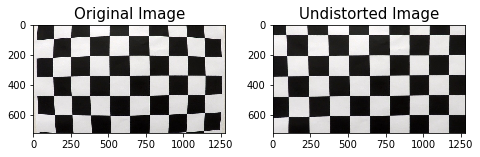

1 ../camera_cal/calibration10.jpg


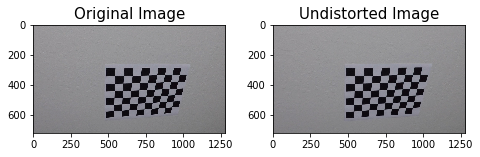

2 ../camera_cal/calibration11.jpg


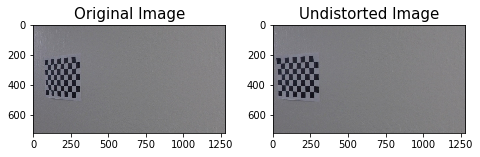

3 ../camera_cal/calibration12.jpg


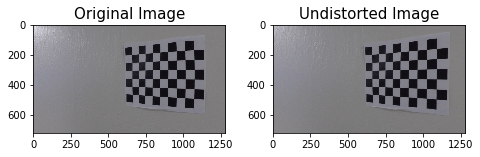

4 ../camera_cal/calibration13.jpg


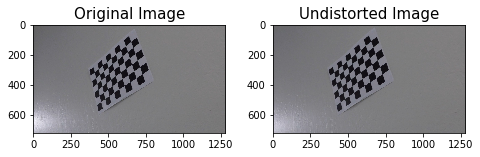

5 ../camera_cal/calibration14.jpg


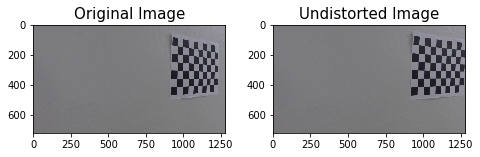

6 ../camera_cal/calibration15.jpg


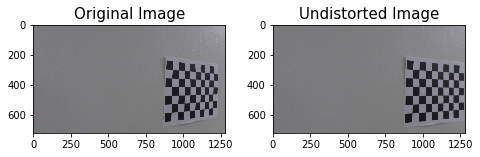

7 ../camera_cal/calibration16.jpg


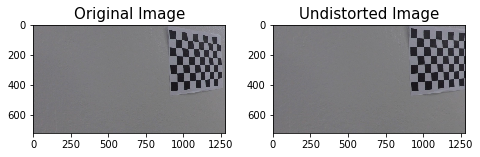

8 ../camera_cal/calibration17.jpg


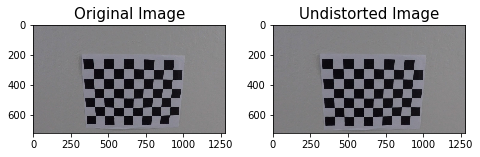

9 ../camera_cal/calibration18.jpg


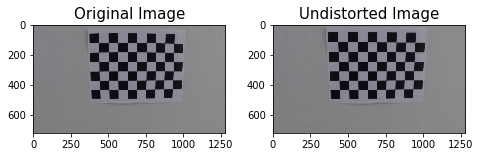

10 ../camera_cal/calibration19.jpg


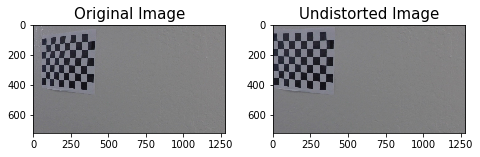

11 ../camera_cal/calibration2.jpg


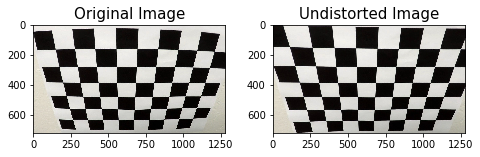

12 ../camera_cal/calibration20.jpg


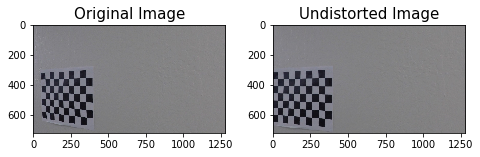

13 ../camera_cal/calibration3.jpg


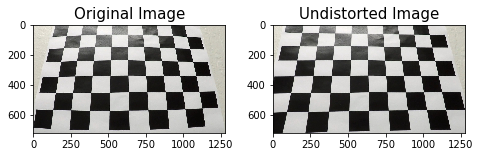

14 ../camera_cal/calibration4.jpg


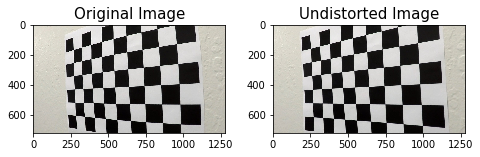

15 ../camera_cal/calibration5.jpg


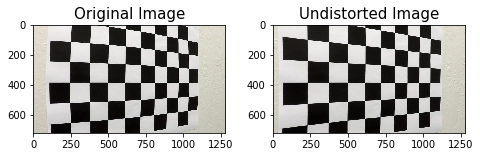

16 ../camera_cal/calibration6.jpg


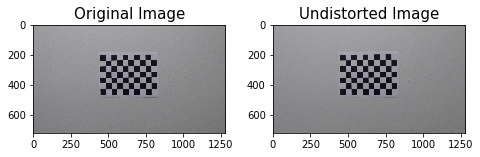

17 ../camera_cal/calibration7.jpg


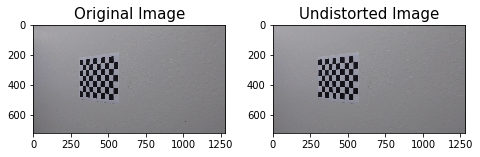

18 ../camera_cal/calibration8.jpg


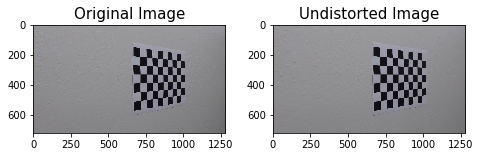

19 ../camera_cal/calibration9.jpg


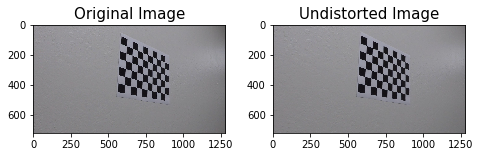

In [2]:
def cal_undistort(img, objpoints=None, imgpoints=None, calibrateCamera=False):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if calibrateCamera:
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        
        camera_calibration = {}
        camera_calibration["mtx"] = mtx
        camera_calibration["dist"] = dist
        pickle.dump(camera_calibration, open("./camera_calibration.p", "wb"))
    else:
        camera_calibration = pickle.load( open( "camera_calibration.p", "rb" ) )
        mtx = camera_calibration["mtx"]
        dist = camera_calibration["dist"]
        
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    #undist = np.copy(dst)
    undist = dst
    return undist

chessboard_corners = pickle.load( open( "chessboard_corners.p", "rb" ) )
objpoints = chessboard_corners["objpoints"]
imgpoints = chessboard_corners["imgpoints"]

# Step through the list and search for chessboard corners
images = glob.glob('../camera_cal/calibration*.jpg')
for idx, fname in enumerate(images):
    img = mpimg.imread(fname)
    undistorted = cal_undistort(img, objpoints, imgpoints, idx==0)

    print(idx, fname)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=15)
    ax2.imshow(undistorted)
    ax2.set_title('Undistorted Image', fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    plt.show()
        


## 3) Apply a distortion correction to raw images

../test_images/test1.jpg


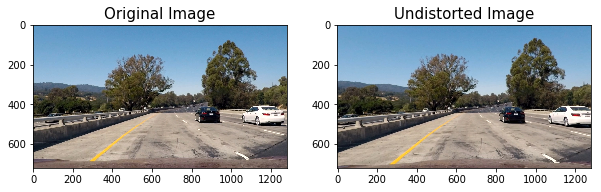

../test_images/test2.jpg


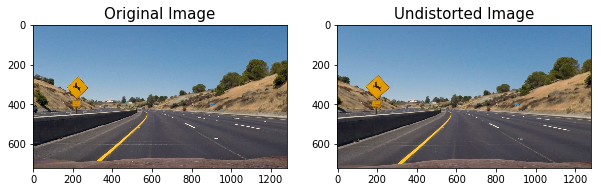

../test_images/test3.jpg


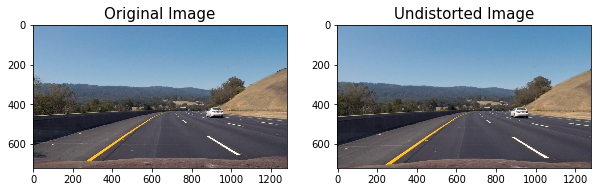

../test_images/test4.jpg


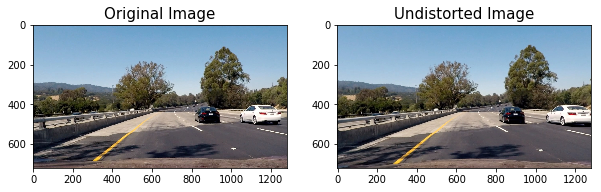

../test_images/test5.jpg


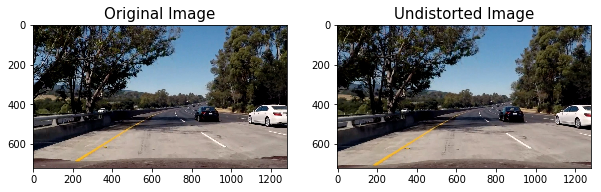

../test_images/test6.jpg


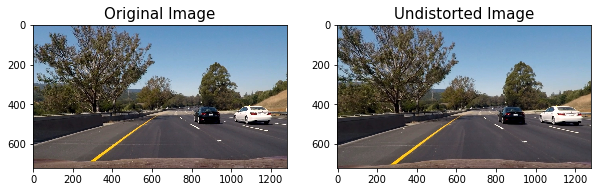

In [3]:
images = glob.glob('../test_images/test*.jpg')

camera_calibration = pickle.load( open( "camera_calibration.p", "rb" ) )
mtx = camera_calibration["mtx"]
dist = camera_calibration["dist"]

for idx, fname in enumerate(images):
    print(fname)
    img = mpimg.imread(fname)    
    #undst = cv2.undistort(img, mtx, dist, None, mtx)
    undistorted = cal_undistort(img)
    #write_name = 'undistorted_test' + str(idx) + '.jpg'
    #cv2.imwrite(write_name, undst)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize = 15)
    ax2.imshow(undistorted)
    ax2.set_title('Undistorted Image', fontsize = 15)
    
    plt.show()

## 4) Create a thresholded binary image

In [9]:
def abs_sobel_thresh(single_channel_image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(single_channel_image, cv2.CV_64F, 1, 0, sobel_kernel))
    elif orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(single_channel_image, cv2.CV_64F, 0, 1, sobel_kernel))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return grad_binary


def mag_thresh(single_channel_image, sobel_kernel=3, mag_thresh=(0, 255)):

    sobelx = cv2.Sobel(single_channel_image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(single_channel_image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 

    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    return mag_binary

def dir_threshold(single_channel_image, sobel_kernel=3, thresh=(0, np.pi/2)):

    sobelx = cv2.Sobel(single_channel_image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(single_channel_image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))

    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return dir_binary

../test_images/test1.jpg


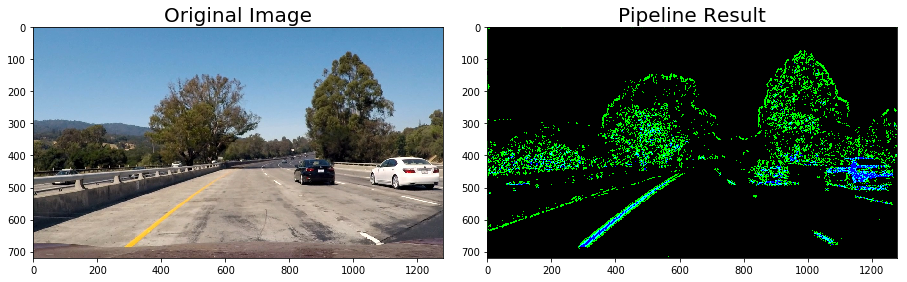

../test_images/test2.jpg


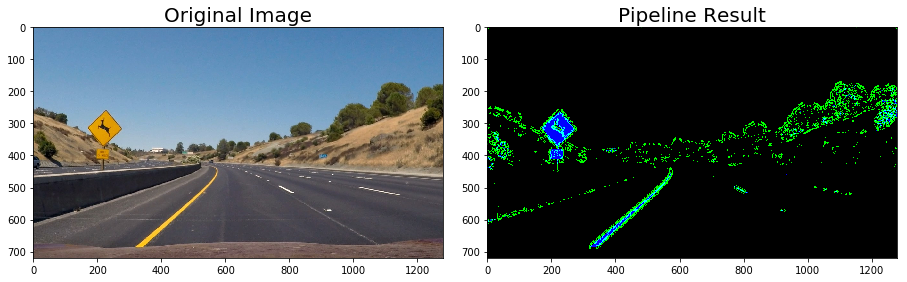

../test_images/test3.jpg


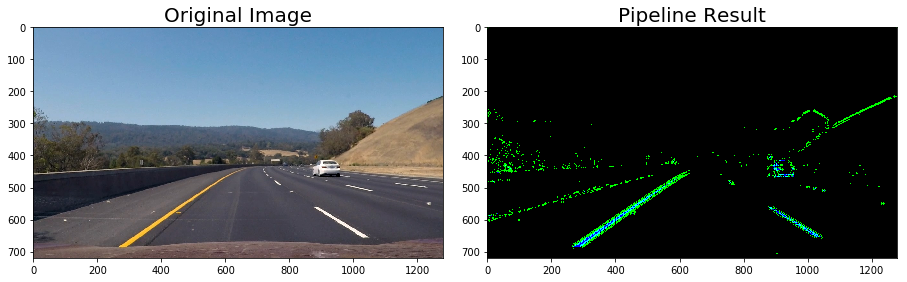

../test_images/test4.jpg


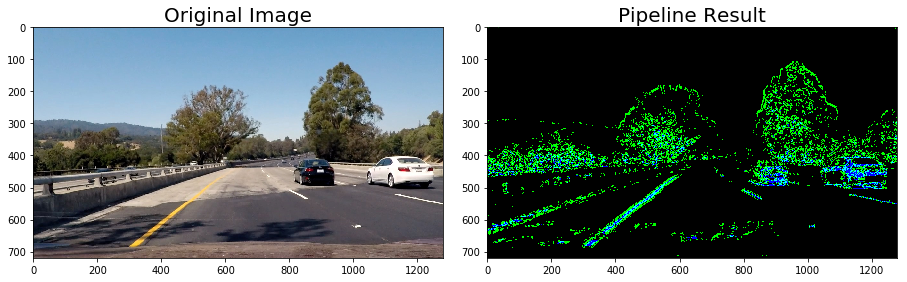

../test_images/test5.jpg


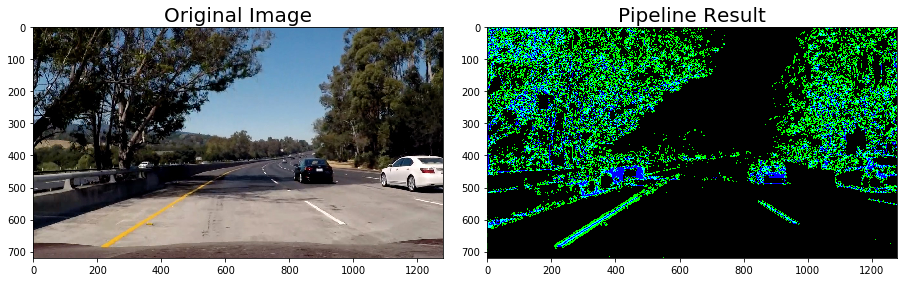

../test_images/test6.jpg


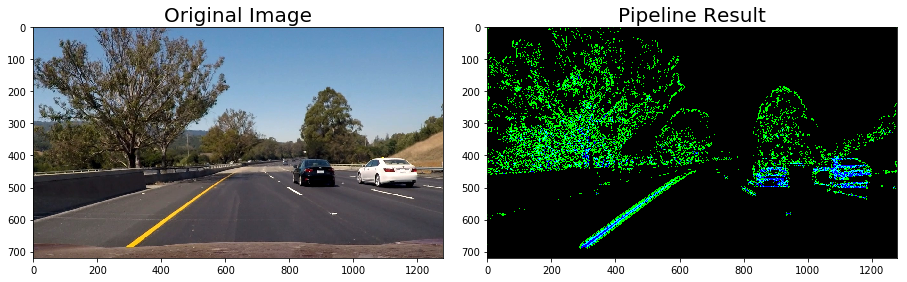

In [46]:
#import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#%matplotlib qt
import pickle

# Edit this function to create your own pipeline.
def pipeline(img, thresholds, ksize=3, debug=False):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Gradient Thesholds
    single_ic = s_channel
    grad_x = abs_sobel_thresh(single_ic, orient='x', sobel_kernel=ksize, thresh=thresholds['grad_x'])
    grad_y = abs_sobel_thresh(single_ic, orient='y', sobel_kernel=ksize, thresh=thresholds['grad_y'])
    grad_mag = mag_thresh(single_ic, sobel_kernel=ksize, mag_thresh=thresholds['grad_mag'])
    grad_dir = dir_threshold(single_ic, sobel_kernel=ksize, thresh=thresholds['grad_dir'])
    grad_combined = np.zeros_like(grad_dir)
    #grad_combined[((grad_x == 1) & (grad_y == 1)) | ((grad_mag == 1) & (grad_dir == 1))] = 1
    grad_combined[((grad_x == 1)) | ((grad_mag == 1) & (grad_dir == 1))] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresholds['grad_col'][0]) & (s_channel <=  thresholds['grad_col'][1])] = 1
    
    # Stack each channel
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    color_binary = np.dstack(( np.zeros_like(grad_x), grad_combined, s_binary))
    
    if debug:
        return grad_combined, grad_x, grad_y, grad_mag, grad_dir, single_ic
    else:
        return color_binary

images = glob.glob('../test_images/test*.jpg')
thresholds = {
    'grad_col': (170, 255),
    'grad_x': (20, 100),
    'grad_y': (20, 100),
    'grad_mag': (40, 100),
    'grad_dir': (0.8, 1.3)
}
debug = False
for idx, fname in enumerate(images):
    if debug:
        if idx > 0:
            continue
        print(fname)
        image = mpimg.imread(fname)
        result, _x, _y, _mag, _dir, sic_image = pipeline(image, thresholds, ksize=23, debug=debug)

        font_size = 10
        f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 9))
        f.tight_layout()
        ax1.imshow(sic_image)
        ax1.set_title('Original Image', fontsize=font_size)
        ax2.imshow(_x, cmap='gray')
        ax2.set_title('GradX Result', fontsize=font_size)
        ax3.imshow(_y, cmap='gray')
        ax3.set_title('GradY', fontsize=font_size)
        ax4.imshow(_mag, cmap='gray')
        ax4.set_title('GradMag', fontsize=font_size)
        ax5.imshow(_dir, cmap='gray')
        ax5.set_title('GradDir', fontsize=font_size)
        ax6.imshow(result, cmap='gray')
        ax6.set_title('GradCombo', fontsize=font_size)
        plt.show()
    else:
        print(fname)
        image = mpimg.imread(fname)
        result = pipeline(image, thresholds, ksize=23, debug=debug)

        # Plot the result
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 9))
        f.subplots_adjust(hspace=0.3)
        f.tight_layout()
        ax1.imshow(image)
        ax1.set_title('Original Image', fontsize=20)
        ax2.imshow(result, cmap='gray')
        ax2.set_title('Pipeline Result', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()

## 5) Apply perspective transform

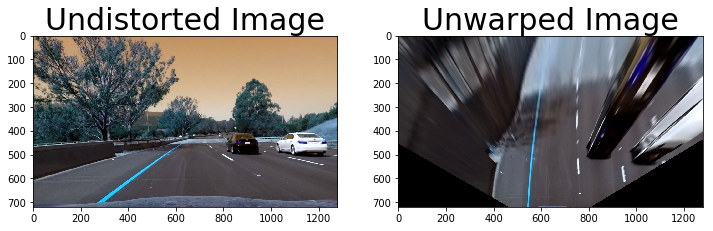

In [4]:
%run 'imports.py'

camera_calibration = pickle.load( open( "camera_calibration.p", "rb" ) )
mtx = camera_calibration["mtx"]
dist = camera_calibration["dist"]

images = glob.glob('../test_images/test*.jpg')
img = cv2.imread(images[5])
undist = cv2.undistort(img, mtx, dist, None, mtx)
imshape = undist.shape
h,w = imshape[:2]
src = np.float32([(600,440),
                  (710,440), 
                  (200,690), 
                  (1100,690)])
dst = np.float32([(520,0),
                  (w-520,0),
                  (520,h),
                  (w-520,h)])

def unwarp(img, src, dst):
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

blk_img = np.zeros_like(img)

# Draw a diagonal blue line with thickness of 5 px
cv2.line(blk_img,(0,0),(511,511),(255,0,0),5)

img_unwarp, M, Minv = unwarp(undist, src, dst)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 9))
#f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(undist)
ax1.set_title('Undistorted Image', fontsize=15)
ax2.imshow(img_unwarp)
ax2.set_title('Unwarped Image', fontsize=15)
plt.show()